<a href="https://colab.research.google.com/github/yacanom/MINE-4210_202320_ANALISIS_CON_DEEP_LEARNING/blob/main/%20Laboratorio%203/MINE4210_ADL2023_LAB3_Pr%C3%A1ctica_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Laboratorio 3 - Sesión 1**
## **Redes Neuronales Recurrentes**

## **Objetivos**
*   Analizar la construcción de una Red Neuronal Recurrente.
*   Entrenar una red recurrente LSTM para resolver un problema de análisis de sentimientos.


## **Problema**
- Se requiere realizar el análisis de sentimientos de un conjunto de frases del sector financiero como parte de la evaluación del sentimiento del mercado y la reputación de empresas, con el objetivo de tomar decisiones de inversión informadas.

## 0. Importación de Librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=77f1a10325f27af4906371ba886936d60fa04642fa7e57dc4f2bb7d5d76eff35
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import num2words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

import tensorflow as tf
import keras_tuner as kt

import contractions
import unicodedata, re

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, TextVectorization, Embedding, SpatialDropout1D

#from keras import backend as K
#from keras import applications
#from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
from PIL import Image
import shutil

print('Tensorflow version:', tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend
Tensorflow version: 2.13.0


##**1. Entendimiento del Negocio**

Una empresa del sector financiero requiere realizar el análisis de sentimientos de un conjunto de frases del sector para poder hacer evaluación del sentimiento del mercado y la reputación de las empresas.

En primer lugar, este análisis proporciona información valiosa para la toma de decisiones de inversión. Al evaluar el sentimiento del mercado a partir de las opiniones y comentarios expresados en las frases, los inversores pueden tomar decisiones más informadas. Esto permite identificar tendencias emergentes, detectar posibles riesgos y oportunidades, y ajustar sus carteras de inversión de acuerdo a la dinámica del mercado.

Los datos se toman de https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

##**2. Perfilamiento y entendimiento de los datos**

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d sbhatti/financial-sentiment-analysis
! unzip /content/financial-sentiment-analysis.zip

  0% 0.00/276k [00:00<?, ?B/s]
100% 276k/276k [00:00<00:00, 98.4MB/s]
Archive:  /content/financial-sentiment-analysis.zip
  inflating: data.csv                


In [ ]:
data = pd.read_csv('/content/data.csv')
data.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


Realizamos la revisión de texto para cada uno de los sentimientos:

In [ ]:
unique_sentiments = data['Sentiment'].unique()

for sentiment in unique_sentiments:
    row = data[data['Sentiment'] == sentiment].iloc[0]  # Obtener la primera fila con el valor de sentimiento específico
    print("Sentiment:", sentiment)
    print("Sentence:", row['Sentence'])
    print()


Sentiment: positive
Sentence: The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .

Sentiment: negative
Sentence: $ESI on lows, down $1.50 to $2.50 BK a real possibility

Sentiment: neutral
Sentence: According to the Finnish-Russian Chamber of Commerce , all the major construction companies of Finland are operating in Russia .



In [ ]:
data["Sentiment"].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

##**3. Preparación de los Datos**

El objetivo del preprocesamiento es limpiar y estandarizar el texto para que sea más adecuado para su uso.

In [ ]:
def remove_stopwords(words):
  for word in STOPWORDS:
    token = ' ' + word + ' '
    words = re.sub(token, ' ', words)
  return words

def preproccesing(words):
    #pasar el texto a minúsculas
    words = words.lower()
    #pasar números a palabras
    #words = re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), words)
    #remove_punctuation se omite el caracter - dado que en inglés se usa en palabras compuestas.
    words = re.sub(r"([\"(),¡!¿?:;'></]|\\s)+", "", words)
    #Remove non-ASCII characters
    words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #Remove Stopwords
    words = remove_stopwords(words)
    #Stem and lemma
    #words = stem_and_lemmatize(words)
    return words

In [ ]:
data["Sentence"] = data["Sentence"].apply(contractions.fix)
data["Sentence"] = data["Sentence"].apply(preproccesing)

In [ ]:
data["Sentence"]

0       the geosolutions technology leverage benefon g...
1               $esi lows $1.50 $2.50 bk real possibility
2       for last quarter 2010  componenta net sales do...
3       according finnish-russian chamber commerce  ma...
4       the swedish buyout firm sold remaining 22.4 pe...
                              ...                        
5837    rising costs forced packaging producer huhtama...
5838    nordic walking first used summer training meth...
5839    according shipping company viking line  eu dec...
5840    in building home improvement trade  sales decr...
5841    helsinki afx - kci konecranes said order four ...
Name: Sentence, Length: 5842, dtype: object

Ahora vamos a pasar el sentimiento (clase) a un valor entero usando LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])

etiquetas_unicas = label_encoder.classes_
for valor_numerico, etiqueta_original in enumerate(etiquetas_unicas):
    print(f'Valor numérico: {valor_numerico}, Etiqueta original: {etiqueta_original}')

Valor numérico: 0, Etiqueta original: negative
Valor numérico: 1, Etiqueta original: neutral
Valor numérico: 2, Etiqueta original: positive


Hacemos la división de los conjuntos para entrenamiento, validación y prueba:

In [ ]:
# Divide los datos en entrenamiento y prueba
train, test = train_test_split(data, test_size=0.2, stratify=data['Sentiment'], random_state=42, shuffle = True)

# Ahora divide el conjunto de entrenamiento en entrenamiento y validación
train, val = train_test_split(train, test_size=0.2, stratify=train['Sentiment'], random_state=42, shuffle = True)

print("Tamaño de datos de entrenamiento:", train.shape)
print("Tamaño de datos de validación:", val.shape)
print("Tamaño de datos de prueba:", test.shape)

train

Tamaño de datos de entrenamiento: (3738, 2)
Tamaño de datos de validación: (935, 2)
Tamaño de datos de prueba: (1169, 2)


,Sentence,Sentiment
3097,digia also set two subsidiaries digia norway ...,1
5048,$bbry sierra. great cash balance impressive gr...,2
5727,britains ftse gains land securities dividend hike,2
185,the finnish company sold uk operation - consis...,1
4265,russian media ventures minority shareholder p...,1
...,...,...
326,i&h move enhance growth .,2
2821,in addition 29 employees laid notice whole wo...,0
4365,the paper industry de-inking sludge produced ...,1
1603,$je looks like bouncing. would nice finish $6...,2


Separamos las oraciones y el sentimiento que representan.


In [ ]:
X_train, X_test, X_val= train['Sentence'], test['Sentence'], val['Sentence']
y_train, y_test, y_val= train['Sentiment'], test['Sentiment'], val['Sentiment']

print("x_train", X_train.shape, " y_train:", y_train.shape)
print("x_test:", X_test.shape, "y_test", y_test.shape)
print("x_val", X_val.shape, "y_val:", y_val.shape)

X_train

x_train (3738,)  y_train: (3738,)
x_test: (1169,) y_test (1169,)
x_val (935,) y_val: (935,)


3097    digia also set two subsidiaries  digia norway ...
5048    $bbry sierra. great cash balance impressive gr...
5727    britains ftse gains land securities dividend hike
185     the finnish company sold uk operation - consis...
4265    russian media ventures  minority shareholder p...
                              ...                        
326                            i&h  move enhance growth .
2821    in addition  29 employees laid notice whole wo...
4365    the paper industry de-inking sludge  produced ...
1603    $je looks like bouncing.  would nice finish $6...
200     a survey conducted taloustutkimus sampo life s...
Name: Sentence, Length: 3738, dtype: object

Revisamos la dristibución de sentimientos del conjunto de entrenamiento:

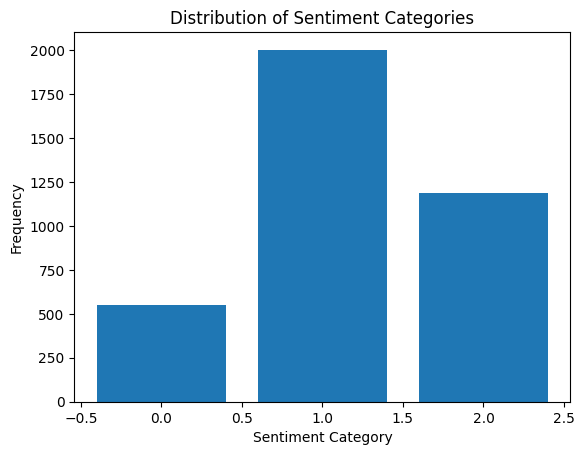

In [ ]:
# Create a bar plot to visualize the distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Categories')
plt.show()

Vamos a pasar los datos de texto a un tensor:

In [ ]:
X_train_tf = tf.convert_to_tensor(X_train)
X_val_tf = tf.convert_to_tensor(X_val)
X_test_tf = tf.convert_to_tensor(X_test)

X_train_tf

<tf.Tensor: shape=(3738,), dtype=string, numpy=
array([b'digia also set two subsidiaries  digia norway digia usa inc. .',
       b'$bbry sierra. great cash balance impressive growth rate.would wonderful marriage',
       b'britains ftse gains land securities dividend hike', ...,
       b'the paper industry de-inking sludge  produced mills use recycled fiber printing ink removed recovered paper  also suitable raw material .',
       b'$je looks like bouncing.  would nice finish $6 today make hammer.  nice volume 5.77 bottom.  fingers crossed',
       b'a survey conducted taloustutkimus sampo life shows companies badly prepared losing key staff members .'],
      dtype=object)>

Ahora hacemos la definición de la capa Vectorize, que se utiliza para tokenización de los textos, y será el punto de entrada de nuestra red neuronal.

[***tf.keras.layers.TextVectorization***](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) es una capa de preprocesamiento que convierte características de texto en secuencias de enteros. Esta capa es útil para preparar datos de texto para su uso en modelos de aprendizaje automático.

El preprocesamiento contiene los siguientes pasos:

*   Normalizar cada ejemplo (normalmente minúsculas + eliminación de puntuación)
*   Dividir cada ejemplo en subcadenas (normalmente palabras).
*   Recombinar las subcadenas en tokens (normalmente ngramas)
*   Indexar los tokens (asociar un valor int único a cada token)
*   Transformar cada ejemplo utilizando este índice, ya sea en un vector de ints o en un vector denso de floats.

In [ ]:
#Capa para tokenización
vectorize_layer = TextVectorization(
    standardize=None,
    split = "whitespace",
    max_tokens=None,
    output_mode='int',
    output_sequence_length=None)

# El método adapt permite construir el vocabulario.
vectorize_layer.adapt(X_train_tf)

A continuación un ejemplo de cómo quedan los datos después de aplicar la la tokenización

In [ ]:
# Tokenizar tus datos
X_train_tk = vectorize_layer(X_train)
X_val_tk = vectorize_layer(X_val)
X_test_tk = vectorize_layer(X_test)

row_index = 2
print("Texto original en X_train:", X_train[row_index], end="\n")
print("Texto tokenizado en X_train_tk:", X_train_tk[row_index])


Texto original en X_train: for last quarter 2010  componenta net sales doubled eur131m eur76m period year earlier  moved zero pre-tax profit pre-tax loss eur7m .
Texto tokenizado en X_train_tk: tf.Tensor(
[1746  341  666 1096 1886  178 3698    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)


Veamos como queda la representación del vocabulario del conjunto X_train

In [ ]:
print("Vocabulario:", vectorize_layer.get_vocabulary())


Vocabulario: ['', '[UNK]', '.', 'eur', 'the', 'company', 'mn', 'sales', 'profit', 'said', 'finnish', 'net', 'million', '%', 'operating', '-', '2008', 'year', 'group', 'period', '2009', 'quarter', 'finland', 'mln', '2007', 'new', 'share', 'business', 'first', '``', '$', 'oyj', '2010', 'market', 'shares', 'in', 'loss', 'also', 'compared', 'services', 'today', 'helsinki', 'euro', 'operations', 'corresponding', '2006', 'bank', 'contract', 'percent', 'pct', 'per', 'financial', 'stock', 'price', 'corporation', 'products', 'nokia', 'decreased', 'total', 'according', 'capital', '&', 'production', 'plant', 'technology', 'hel', 'companies', 'omx', 'would', '2005', 'third', 'service', 'solutions', 'last', 'increased', 'earlier', 'rose', 'mobile', 'investment', 'well', 'value', 'unit', 'fell', 'expected', 'result', 'one', 'totalled', 'order', 'lower', 'increase', 'development', 'deal', 'customers', 'building', 'second', 'plc', 'management', 'growth', 'oy', 'maker', 'long', 'earnings', 'ceo', 'two'

In [ ]:
print("Configuración:", vectorize_layer.get_config())


Configuración: {'name': 'text_vectorization', 'trainable': True, 'dtype': 'string', 'batch_input_shape': (None,), 'max_tokens': None, 'standardize': None, 'split': 'whitespace', 'ngrams': None, 'output_mode': 'int', 'output_sequence_length': None, 'pad_to_max_tokens': False, 'sparse': False, 'ragged': False, 'vocabulary': None, 'idf_weights': None, 'encoding': 'utf-8', 'vocabulary_size': 10523}


Analizamos y visualizamos la longitud de las secuencias de texto en el conjunto de entrenamiento X_train

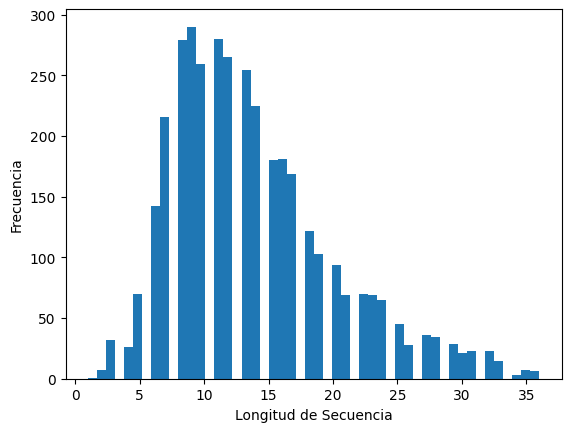

In [ ]:
sequence_lengths = [len(text.split()) for text in X_train]
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Longitud de Secuencia')
plt.ylabel('Frecuencia')
plt.show()


##**4. Modelamiento**

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    # tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
]

Definiremos la arquitectura de nuestra Red Neuronal Base. Dado que es un problema multiclase se usa ***sparse_categorical_crossentropy*** como función de pérdida y se establecen 3 neuronas en la capa de salida.

Para la entrada usaremos la capa **vectorize_layer** (definida anteriormente), seguido de una capa de **Embedding** que es una de las capas fundamentales en el procesamiento de lenguaje natural (NLP) en modelos de redes neuronales. Su función principal es convertir palabras o tokens en representaciones numéricas, lo que permite que los modelos de aprendizaje automático trabajen con texto.

También usaremos la capa **SpatialDropout1D** es una técnica de regularización que desactiva secuencias completas en lugar de nodos individuales y puede ser útil en modelos de procesamiento de lenguaje natural para prevenir el sobreajuste y mejorar la generalización del modelo.

La capa **LSTM** (Long Short-Term Memory) es una capa especializada en redes neuronales recurrentes (RNN) y secuencias temporales debido a su capacidad para manejar secuencias largas y capturar dependencias a largo plazo.

In [ ]:
model = Sequential()

model.add(vectorize_layer)
model.add(Embedding(10000, 300, name="Capa_Embedding"))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1024, activation='relu', name='Capa_Oculta'))
model.add(Dropout(0.8))
model.add(Dense(3, activation='softmax', name='Capa_Salida'))  # 3 para 3 clases

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with tf.device('/device:GPU:0'):
  model.fit(
      X_train_tf, y_train,
      validation_data = (X_val_tf, y_val),
      epochs=20,
      callbacks=my_callbacks)

Epoch 1/20
117/117 [==============================] - 53s 340ms/step - loss: 1.0000 - accuracy: 0.5324 - val_loss: 1.0008 - val_accuracy: 0.5358
Epoch 2/20
117/117 [==============================] - 23s 191ms/step - loss: 0.8782 - accuracy: 0.6156 - val_loss: 0.8540 - val_accuracy: 0.6225
Epoch 3/20
117/117 [==============================] - 20s 169ms/step - loss: 0.6593 - accuracy: 0.7517 - val_loss: 0.8192 - val_accuracy: 0.6973
Epoch 4/20
117/117 [==============================] - 18s 156ms/step - loss: 0.4693 - accuracy: 0.8034 - val_loss: 0.9773 - val_accuracy: 0.6695
Epoch 5/20
117/117 [==============================] - 21s 180ms/step - loss: 0.3433 - accuracy: 0.8488 - val_loss: 1.1699 - val_accuracy: 0.5968
Epoch 6/20
117/117 [==============================] - 18s 152ms/step - loss: 0.2501 - accuracy: 0.8986 - val_loss: 1.2335 - val_accuracy: 0.6428
Epoch 7/20
117/117 [==============================] - 25s 215ms/step - loss: 0.2338 - accuracy: 0.9005 - val_loss: 1.2782 - val_ac

### Evaluación

Generamos ahora predicciones del modelo base con los datos de entrenamiento:

In [ ]:
y_pred = model.predict(X_train_tf)
y_pred = np.argmax(y_pred, axis=1)
y_pred

117/117 [==============================] - 2s 18ms/step


array([1, 2, 2, ..., 1, 2, 1])

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.44      0.59       550
           1       0.86      0.98      0.92      2003
           2       0.98      0.98      0.98      1185

    accuracy                           0.90      3738
   macro avg       0.90      0.80      0.83      3738
weighted avg       0.90      0.90      0.89      3738



Generamos ahora predicciones del modelo base con los datos de test:

In [ ]:
y_pred_test = model.predict(X_test_tf)
y_pred_test = np.argmax(y_pred_test, axis=1)

print(classification_report(y_test, y_pred_test))

37/37 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0       0.27      0.26      0.26       172
           1       0.73      0.76      0.74       626
           2       0.67      0.64      0.65       371

    accuracy                           0.65      1169
   macro avg       0.56      0.55      0.55      1169
weighted avg       0.64      0.65      0.65      1169



Este modelo básico presenta sobreajuste. Para mejorarlo, necesitamos realizar una búsqueda de hiperparámetros para lograr una mejor generalización del modelo como lo pueden ser:

Hiperparámetros de la capa LSTM
*   units
*   dropout y recurrent_dropout

Hiperparámetros de la capa de embedding
*   input_dim
*   output_dim

Hiperparámetros de capas de dropout:
*   rate

Tamaño del vocabulario y longitud de secuencia

Número de capas ocultas

Tamaño del batch y número de épocas


### Usando Glove

Ahora vamos a implementar una red neuronal usando un embedding pre-entrenado como lo es [GloVe (Global Vectors for Word Representation)](https://nlp.stanford.edu/projects/glove/)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2023-10-17 00:24:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-10-17 00:24:41--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-10-17 00:24:41--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Ahora cargamos los vectores de palabras pre-entrenados desde un archivo GloVe y los almacenamos en un diccionario en el que se puede buscar una palabra específica para obtener su vector correspondiente.

In [ ]:
glove_embeddings = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector


Creamos la matriz de incrustación (embedding matrix) que contiene los vectores GloVe correspondientes a las palabras del vocabulario que se tomó del conjunto de entrenamiento X_train

In [ ]:
# Número de palabras del vocabulario
num_words = vectorize_layer.vocabulary_size() + 1  # +1 para tener en cuenta la palabra OOV (Out of Vocabulary)

embedding_dim = 100  # Elige la dimensión de los vectores GloVe (por ejemplo, 100 para 'glove.6B.100d.txt')

word_index = dict(zip(vectorize_layer.get_vocabulary(), range(len(vectorize_layer.get_vocabulary()))))

# Crea la matriz de incrustación
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Las palabras en GloVe se establecen en la matriz de incrustación
        embedding_matrix[i] = embedding_vector


Determinamos la longitud máxima de secuencia dentro de tu conjunto de datos de entrenamiento. Esta longitud máxima es importante ya que establece el límite máximo de palabras en una secuencia que el modelo puede manejar.

In [ ]:
max_sequence_length = max(len(seq) for seq in X_train)
max_sequence_length

269

Definimos nuestra red usando el Embedding pre-entrenado.

```
model3.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
```

>  input_dim=len(word_index) + 1: El parámetro input_dim se establece en la longitud del word_index, que es el índice de palabras en tu conjunto de datos de entrenamiento. Agregamos 1 porque generalmente se suma 1 para incluir una entrada especial para palabras fuera del vocabulario (OOV - Out of Vocabulary).

>  output_dim=embedding_dim: output_dim se establece en embedding_dim, que es la dimensión de los vectores de incrustación que se utilizarán. En este caso, coincidirá con la dimensión de los vectores GloVe pre-entrenados.

>  input_length=max_sequence_length: Aquí establecemos la longitud de entrada máxima para las secuencias que se utilizarán en esta capa de incrustación. Esta longitud se definió previamente como max_sequence_length y se utiliza para asegurarse de que las secuencias se ajusten a la longitud máxima especificada.

>  weights=[embedding_matrix]: weights se establece en embedding_matrix, que es la matriz de incrustación pre-entrenada. Esta matriz contiene los vectores GloVe pre-entrenados para las palabras de tu vocabulario.

>  trainable=False: trainable se establece en False, lo que significa que los vectores de incrustación no se entrenarán o modificarán durante el entrenamiento del modelo.


In [ ]:
model3 = Sequential()

model3.add(vectorize_layer)
model3.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model3.add(SpatialDropout1D(0.3))
model3.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))
model3.add(Dense(1024, activation='relu', name='Capa_Oculta'))
model3.add(Dropout(0.8))
model3.add(Dense(3, activation='softmax', name='Capa_Salida'))  # 3 para 3 clases

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Entrenamos la red neuronal:

In [ ]:
with tf.device('/device:GPU:0'):
  model3.fit(
      X_train_tf, y_train,
      validation_data = (X_val_tf, y_val),
      epochs=20,
      callbacks=my_callbacks)

Epoch 1/20
117/117 [==============================] - 24s 150ms/step - loss: 0.9463 - accuracy: 0.5688 - val_loss: 0.8641 - val_accuracy: 0.6235
Epoch 2/20
117/117 [==============================] - 20s 172ms/step - loss: 0.8973 - accuracy: 0.6051 - val_loss: 0.8266 - val_accuracy: 0.6267
Epoch 3/20
117/117 [==============================] - 16s 133ms/step - loss: 0.8767 - accuracy: 0.6057 - val_loss: 0.8508 - val_accuracy: 0.6096
Epoch 4/20
117/117 [==============================] - 26s 222ms/step - loss: 0.8491 - accuracy: 0.6257 - val_loss: 0.8252 - val_accuracy: 0.6128
Epoch 5/20
117/117 [==============================] - 19s 160ms/step - loss: 0.8498 - accuracy: 0.6169 - val_loss: 0.8239 - val_accuracy: 0.6235
Epoch 6/20
117/117 [==============================] - 29s 251ms/step - loss: 0.8334 - accuracy: 0.6241 - val_loss: 0.8166 - val_accuracy: 0.6182
Epoch 7/20
117/117 [==============================] - 16s 136ms/step - loss: 0.8210 - accuracy: 0.6388 - val_loss: 0.8129 - val_ac

In [ ]:
y_pred = model3.predict(X_train_tf)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_train, y_pred))

117/117 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.59      0.47      0.52       550
           1       0.80      0.93      0.86      2003
           2       0.88      0.74      0.81      1185

    accuracy                           0.80      3738
   macro avg       0.76      0.71      0.73      3738
weighted avg       0.80      0.80      0.79      3738



In [ ]:
y_pred = model3.predict(X_test_tf)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

37/37 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.38      0.31      0.35       172
           1       0.75      0.90      0.81       626
           2       0.75      0.56      0.64       371

    accuracy                           0.70      1169
   macro avg       0.63      0.59      0.60      1169
weighted avg       0.69      0.70      0.69      1169



##**5. Hands on**

1.  ¿Cómo afectaría el Tamaño del Embedding en el rendimiento del Modelo?

2.  Implemente la búsqueda de hiperparámetros para mejorar el modelo base.
